In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
day_price_0_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_0.csv", delimiter=";")
day_price_m1_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-1.csv", delimiter=";")
day_price_m2_df = pd.read_csv("../round-1-island-data-bottle/prices_round_1_day_-2.csv", delimiter=";")

# merge all the dataframes
merged_df = pd.concat([day_price_0_df, day_price_m1_df, day_price_m2_df])


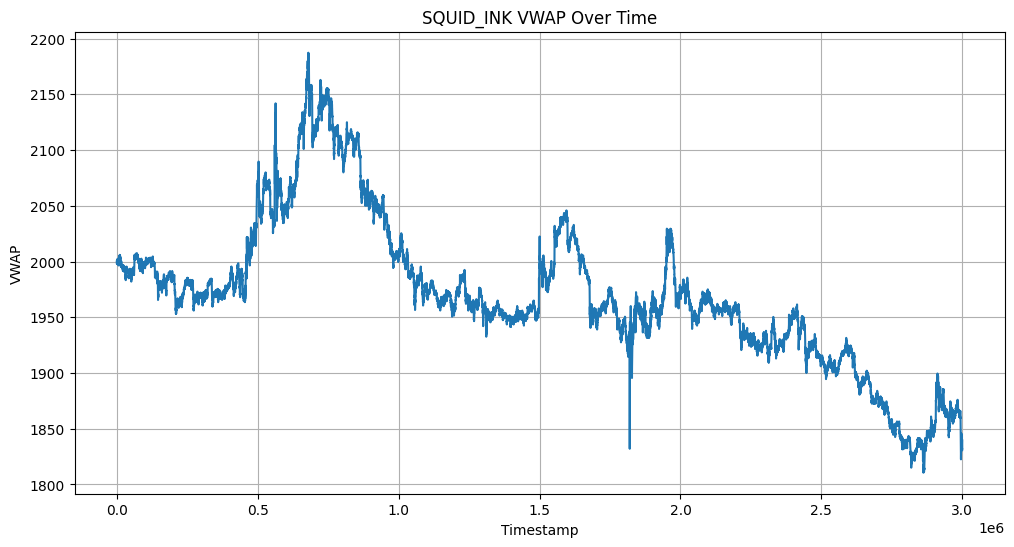

In [6]:
# isolate the squid ink data - create a copy to avoid the warning
squid_ink_df = merged_df[merged_df["product"] == "SQUID_INK"].copy()

squid_ink_df['continuous_timestamp'] = squid_ink_df['timestamp'] + 1e6 * (2 - abs(squid_ink_df['day']))

# Calculate VWAP for each row
def calculate_vwap(row):
    bid_value = sum(
        row[f"bid_price_{i}"] * row[f"bid_volume_{i}"]
        for i in range(1, 4)
        if not (pd.isna(row[f"bid_price_{i}"]) or pd.isna(row[f"bid_volume_{i}"]))
    )
    
    ask_value = sum(
        row[f"ask_price_{i}"] * row[f"ask_volume_{i}"]
        for i in range(1, 4)
        if not (pd.isna(row[f"ask_price_{i}"]) or pd.isna(row[f"ask_volume_{i}"]))
    )
    
    total_volume = sum(
        row[f"{side}_volume_{i}"]
        for side in ["bid", "ask"]
        for i in range(1, 4)
        if not (pd.isna(row[f"{side}_price_{i}"]) or pd.isna(row[f"{side}_volume_{i}"]))
    )
    
    return (bid_value + ask_value) / total_volume if total_volume > 0 else None

# Calculate mid price
def calculate_mid_price(row):
    return (row['ask_price_1'] + row['bid_price_1']) / 2

# Apply VWAP calculation to each row
squid_ink_df['vwap'] = squid_ink_df.apply(calculate_vwap, axis=1)

# Apply mid price calculation to each row
squid_ink_df['mid_price'] = squid_ink_df.apply(calculate_mid_price, axis=1)

# Sort by continuous timestamp
squid_ink_df = squid_ink_df.sort_values('continuous_timestamp')


# Plot
plt.figure(figsize=(12, 6))
plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["vwap"])
# plt.plot(squid_ink_df["continuous_timestamp"], squid_ink_df["mid_price"])
plt.title("SQUID_INK VWAP Over Time")
plt.xlabel("Timestamp")
plt.ylabel("VWAP")
plt.grid(True)
plt.show()


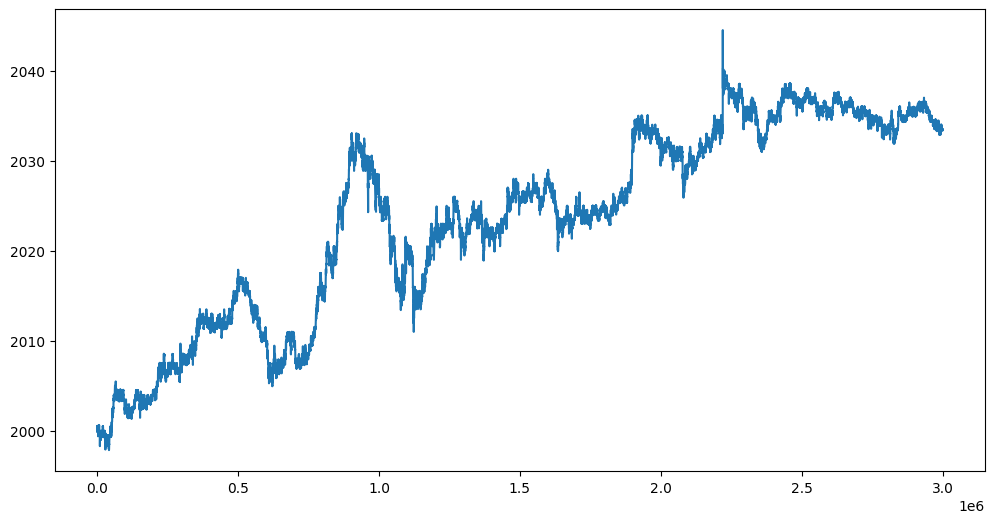

In [ ]:
# do the same for kelp
kelp_df = merged_df[merged_df["product"] == "KELP"].copy()

kelp_df['continuous_timestamp'] = kelp_df['timestamp'] + 1e6 * (2 - abs(kelp_df['day']))

# Calculate VWAP for each row
kelp_df['vwap'] = kelp_df.apply(calculate_vwap, axis=1)

# Calculate mid price
kelp_df['mid_price'] = kelp_df.apply(calculate_mid_price, axis=1)

# sort
kelp_df = kelp_df.sort_values('continuous_timestamp')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(kelp_df["continuous_timestamp"], kelp_df["vwap"])

9995.666666666666 10004.411764705883


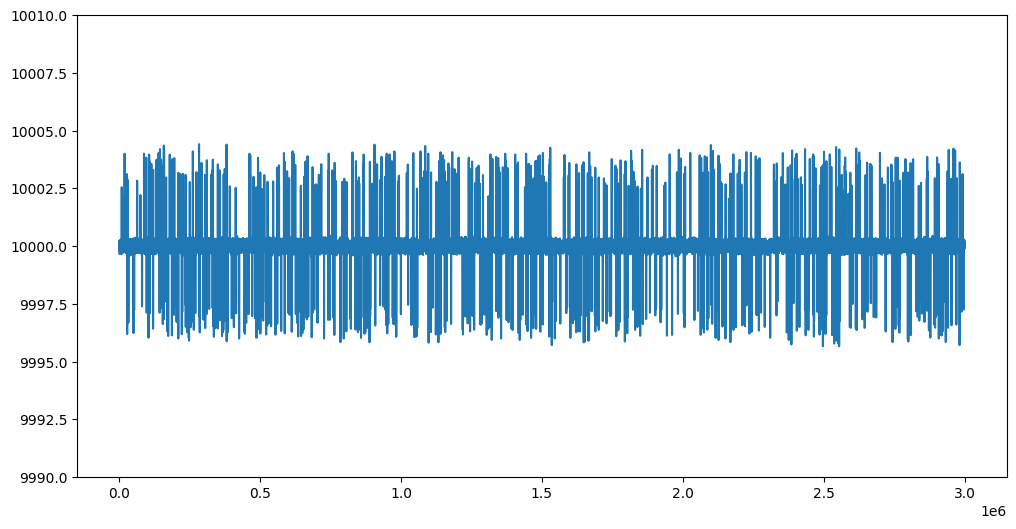

In [17]:
# rainforest resin
rainforest_resin_df = merged_df[merged_df["product"] == "RAINFOREST_RESIN"].copy()

rainforest_resin_df['continuous_timestamp'] = rainforest_resin_df['timestamp'] + 1e6 * (2 - abs(rainforest_resin_df['day']))

# Calculate VWAP for each row
rainforest_resin_df['vwap'] = rainforest_resin_df.apply(calculate_vwap, axis=1)

# Calculate mid price
rainforest_resin_df['mid_price'] = rainforest_resin_df.apply(calculate_mid_price, axis=1)

# sort
rainforest_resin_df = rainforest_resin_df.sort_values('continuous_timestamp')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(rainforest_resin_df["continuous_timestamp"], rainforest_resin_df["vwap"])
plt.ylim(9990, 10010)

print(min(rainforest_resin_df["vwap"]), max(rainforest_resin_df["vwap"]))


In [6]:
# Now fit SARIMA model using pmdarima
import pmdarima as pm

# Create the SARIMA model
model = pm.auto_arima(squid_ink_df['vwap'].dropna(),
                     start_p=1, start_q=1,
                     test='adf',
                     max_p=3, max_q=3,
                     m=12,  # frequency for seasonal differencing
                     start_P=0, seasonal=True,
                     d=1, D=1, # difference order
                     trace=True,
                     error_action='ignore',
                     suppress_warnings=True,
                     stepwise=True)

print(model.summary())

# Plot diagnostics
model.plot_diagnostics(figsize=(12, 8))
plt.show()

/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=62.52 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(0,1,0)[12]             : AIC=145533.837, Time=1.19 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=135800.100, Time=5.82 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=24.88 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,1,0)[12]             : AIC=145411.055, Time=1.24 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,0)[12]             : AIC=132439.329, Time=14.89 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=166.91 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=46.65 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(2,1,0)[12]             : AIC=132593.788, Time=10.41 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,0)[12]             : AIC=132393.306, Time=18.85 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(1,1,0)[12]             : AIC=135740.071, Time=7.48 sec


/Users/vasudev/miniconda3/envs/ml/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


: 